In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm, trange
from numba import njit, objmode


## Simulated position distribution 

In [53]:
def simulate_primaries(size, rate = 50, r_range=(0, 64), z_range=(-142, -6)):
    dt = (1 / rate) * np.ones(size - 1)
    times = np.append([1.0], 1.0 + dt.cumsum()) * 1e9 #time in ns
    times = times.round().astype(np.int64)

    phi = np.random.uniform(size=size) * 2 * np.pi
    r = r_range[1] * np.sqrt(
        np.random.uniform((r_range[0] / r_range[1]) ** 2, 1, size=size)
    )
    z = np.random.uniform(z_range[0], z_range[1], size=size)
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    data = {
        'r': r,
        'x': x,
        'y': y,
        'z': z,
        'times': times
    }
    return pd.DataFrame(data)


In [54]:
df_primaries = simulate_primaries(10000)
df_primaries_center = simulate_primaries(10000, r_range=(0, 15))
df_primaries_edge = simulate_primaries(10000, r_range=(62, 64))

In [55]:
np.sum(df_primaries_edge['r']>63)

5042

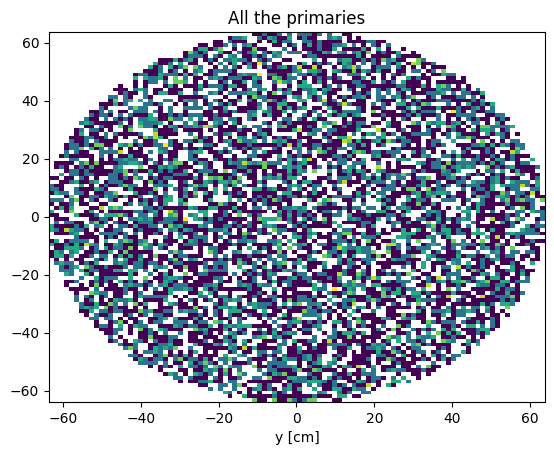

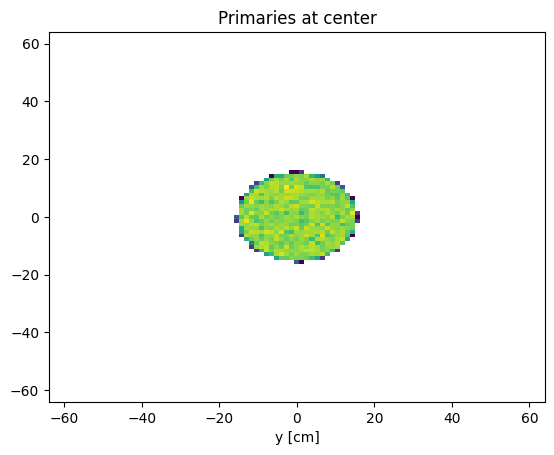

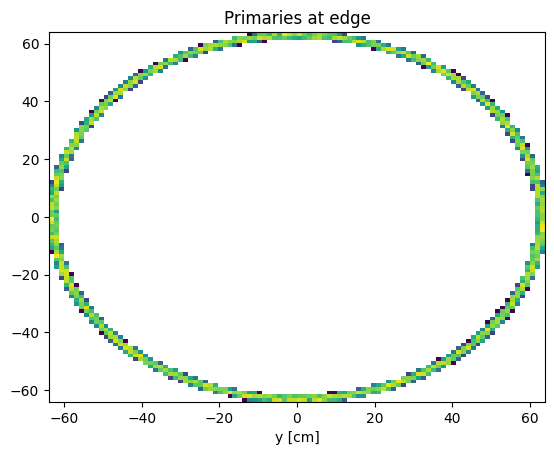

In [56]:
plt.hist2d(df_primaries['x'],df_primaries['y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('All the primaries')
plt.show()
plt.hist2d(df_primaries_center['x'],df_primaries_center['y'],bins=[np.linspace(-64,64,100),np.linspace(-64,64,100)],norm=colors.LogNorm())
plt.xlim(-64,64)
plt.ylim(-64,64)
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Primaries at center')
plt.show()
plt.hist2d(df_primaries_edge['x'],df_primaries_edge['y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Primaries at edge')
plt.show()

In [57]:
PMT_position = pd.read_csv('/project2/lgrandi/astroriya/pmt_positions_xenonnt.csv')
def simulate_lonehits(size, rate = 5e3+10, PMT_range=(0, 493)):
    dt = (1 / rate) * np.ones(size - 1)
    times = np.append([1.0], 1.0 + dt.cumsum()) * 1e9 #time in ns
    times = times.round().astype(np.int64)

    PMT_indices = np.random.choice(PMT_position.index, size=size)
    df = pd.DataFrame({
        'x': PMT_position.iloc[PMT_indices]['x'].values,
        'y': PMT_position.iloc[PMT_indices]['y'].values,
        'array': PMT_position.iloc[PMT_indices]['array'].values,
        'times': times
    })
    return df

In [58]:
df_lonehit = simulate_lonehits(1000000)

In [59]:
def lonehit_matching(df_lonehit,df_primaries):
    df_lonehit['x_primary'] = np.nan
    df_lonehit['y_primary'] = np.nan   
    for i in tqdm(range(0, len(df_primaries) - 1)):
        indices = (df_lonehit['times']>df_primaries['times'][i]) & (df_lonehit['times']<df_primaries['times'][i+1])
        df_lonehit.loc[indices,'x_primary'] = df_primaries['x'][i]
        df_lonehit.loc[indices,'y_primary'] = df_primaries['y'][i]
    df_lonehit = df_lonehit.dropna()
    df_lonehit['distance_sq'] = ((df_lonehit['x'] - df_lonehit['x_primary'])**2 + (df_lonehit['y'] - df_lonehit['y_primary'])**2)
    return df_lonehit

In [60]:
df_lonehit_of_primaries_at_center = lonehit_matching(df_lonehit,df_primaries_center)
top_lonehit_of_primaries_at_center = df_lonehit_of_primaries_at_center[df_lonehit_of_primaries_at_center['array']=='top']
bottom_lonehit_of_primaries_at_center = df_lonehit_of_primaries_at_center[df_lonehit_of_primaries_at_center['array']=='bottom']

100%|██████████| 9999/9999 [00:18<00:00, 541.53it/s]
/tmp/ipykernel_3832995/239058302.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lonehit['distance_sq'] = ((df_lonehit['x'] - df_lonehit['x_primary'])**2 + (df_lonehit['y'] - df_lonehit['y_primary'])**2)


In [61]:
df_lonehit_of_primaries_at_edge = lonehit_matching(df_lonehit,df_primaries_edge)
top_lonehit_of_primaries_at_edge = df_lonehit_of_primaries_at_edge[df_lonehit_of_primaries_at_edge['array']=='top']
bottom_lonehit_of_primaries_at_edge = df_lonehit_of_primaries_at_edge[df_lonehit_of_primaries_at_edge['array']=='bottom']

100%|██████████| 9999/9999 [00:18<00:00, 533.79it/s]
/tmp/ipykernel_3832995/239058302.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lonehit['distance_sq'] = ((df_lonehit['x'] - df_lonehit['x_primary'])**2 + (df_lonehit['y'] - df_lonehit['y_primary'])**2)


In [62]:
df_lonehit = lonehit_matching(df_lonehit,df_primaries)
df_lonehit_top = df_lonehit[df_lonehit['array']=='top']
df_lonehit_bottom = df_lonehit[df_lonehit['array']=='bottom']

100%|██████████| 9999/9999 [00:17<00:00, 565.39it/s]
/tmp/ipykernel_3832995/239058302.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lonehit['distance_sq'] = ((df_lonehit['x'] - df_lonehit['x_primary'])**2 + (df_lonehit['y'] - df_lonehit['y_primary'])**2)


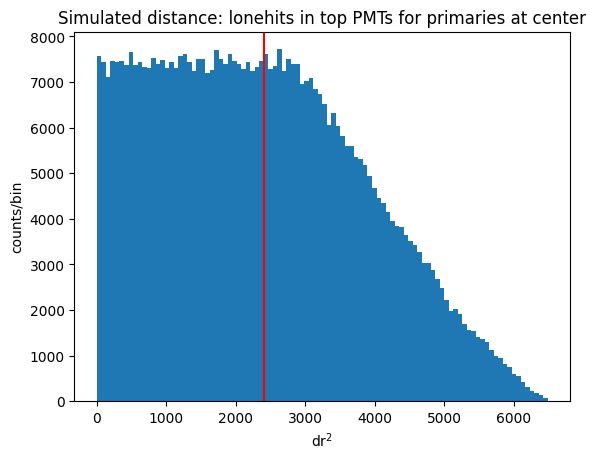

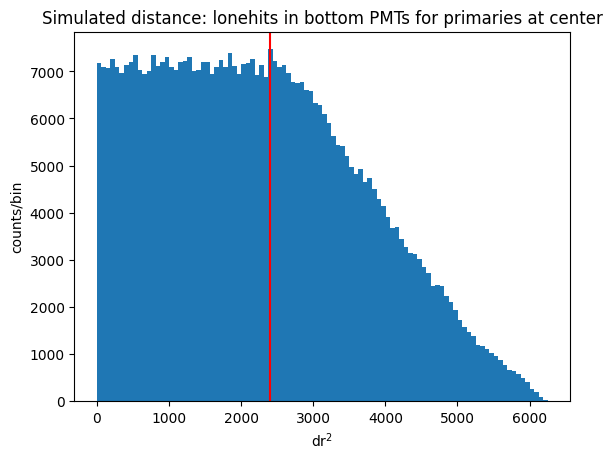

In [63]:
plt.hist(top_lonehit_of_primaries_at_center['distance_sq'],bins=100)
plt.xlabel(r"dr$^2$")
plt.ylabel('counts/bin')
plt.title('Simulated distance: lonehits in top PMTs for primaries at center')
plt.axvline((64-15)**2,color='r')
plt.savefig('Simulated distance: lonehits in top PMTs for primaries at center.svg')
plt.show()
plt.hist(bottom_lonehit_of_primaries_at_center['distance_sq'],bins=100)
plt.xlabel(r"dr$^2$")
plt.ylabel('counts/bin')
plt.title('Simulated distance: lonehits in bottom PMTs for primaries at center')
plt.axvline((64-15)**2,color='r')
plt.savefig('Simulated distance: lonehits in bottom PMTs for primaries at center.svg')
plt.show()

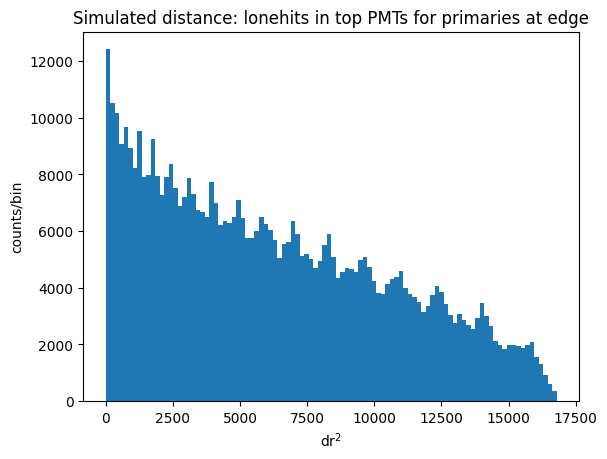

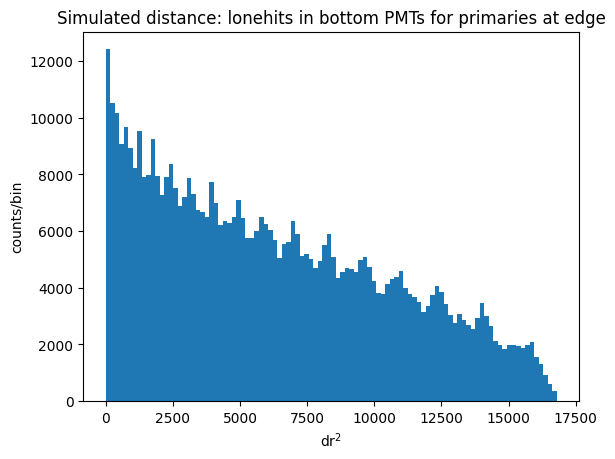

In [64]:
plt.hist(top_lonehit_of_primaries_at_edge['distance_sq'],bins=100)
plt.xlabel(r"dr$^2$")
plt.ylabel('counts/bin')
plt.title('Simulated distance: lonehits in top PMTs for primaries at edge')
plt.savefig('Simulated distance: lonehits in top PMTs for primaries at edge.svg')
plt.show()
plt.hist(top_lonehit_of_primaries_at_edge['distance_sq'],bins=100)
plt.xlabel(r"dr$^2$")
plt.ylabel('counts/bin')
plt.title('Simulated distance: lonehits in bottom PMTs for primaries at edge')
plt.savefig('Simulated distance: lonehits in bottom PMTs for primaries at edge.svg')
plt.show()

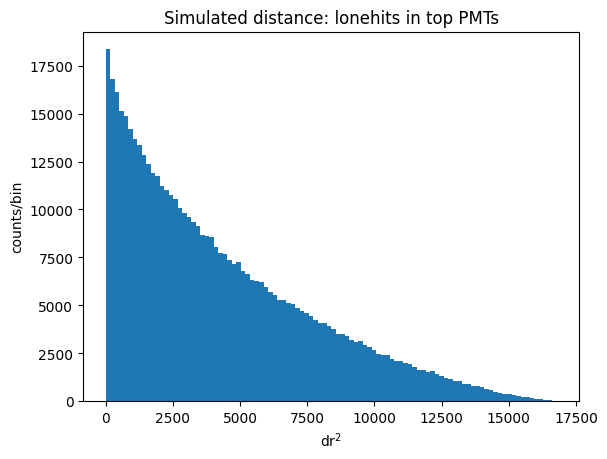

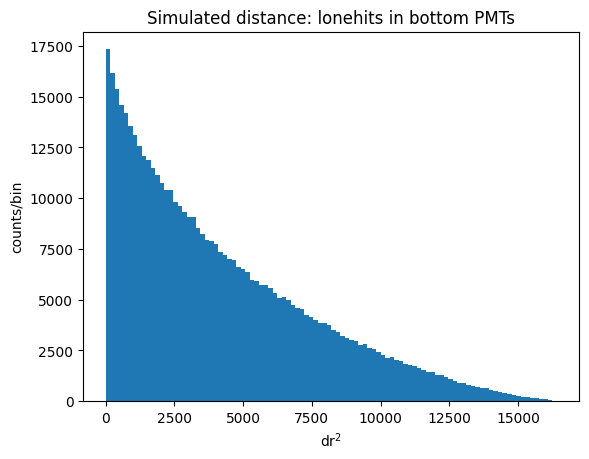

In [65]:
plt.hist(df_lonehit_top['distance_sq'],bins=100)
plt.xlabel(r"dr$^2$")
plt.ylabel('counts/bin')
plt.title('Simulated distance: lonehits in top PMTs')
plt.savefig('Simulated distance: lonehits in top PMTs.svg')
plt.show()
plt.hist(df_lonehit_bottom['distance_sq'],bins=100)
plt.xlabel(r"dr$^2$")
plt.ylabel('counts/bin')
plt.title('Simulated distance: lonehits in bottom PMTs')
plt.savefig('Simulated distance: lonehits in bottom PMTs.svg')
plt.show()

## Observed position distribution

In [2]:
import cutax
import strax
st = cutax.xenonnt_online(_rucio_local_path='/project/lgrandi/rucio', include_rucio_local = True)
st.storage.append(strax.DataDirectory("/project2/lgrandi/xenonnt/processed/", readonly=True))
st.storage.append(strax.DataDirectory("/project/lgrandi/xenonnt/processed/", readonly=True))

You specified _auto_append_rucio_local=True and you are not on dali compute nodes, so we will add the following rucio local path: /project/lgrandi/rucio/


In [3]:
dsets = st.select_runs(
    run_mode = ('background_linked'),
    exclude_tags = ('flash', 'ramp_up', 'ramp_down', 'anode_off', 'abandon', 'hot_spot', 'warm_spot', 'missing_one_pmt', 'messy', 'bad', 'nonsr0_configuration','after_ambe'),
    available = ("peak_basics",'lone_hits')
)

Checking data availability:   0%|          | 0/3 [00:00<?, ?it/s]

/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.9/site-packages/straxen/url_config.py:743: UserWarning: From straxen version 2.1.0 onward, URLConfig parameterswill be sorted alphabetically before being passed to the plugins, this will change the lineage hash for non-sorted URLs. To load data processed with non-sorted URLs, you will need to use an older version.
  warnings.warn(


In [4]:
dsets = dsets.reset_index(drop=True)
dsets

,name,number,mode,end,source,start,tags,livetime,lone_hits_available,event_basics_available,peak_basics_available
0,055769,55769,background_linked,2023-11-14 08:53:53.689,none,2023-11-14 08:18:01.734,_sr2_preliminary,0 days 00:35:51.955000,True,True,True
1,055768,55768,background_linked,2023-11-14 08:17:08.841,none,2023-11-14 05:17:04.735,_sr2_preliminary,0 days 03:00:04.106000,True,True,True
2,055767,55767,background_linked,2023-11-14 05:16:12.315,none,2023-11-14 02:16:08.968,_sr2_preliminary,0 days 03:00:03.347000,True,True,True
3,055766,55766,background_linked,2023-11-14 02:15:17.432,none,2023-11-13 23:15:14.041,_sr2_preliminary,0 days 03:00:03.391000,True,True,True
4,055765,55765,background_linked,2023-11-13 23:14:22.459,none,2023-11-13 20:14:19.093,_sr2_preliminary,0 days 03:00:03.366000,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
631,053511,53511,background_linked,2023-08-09 08:30:50.582,none,2023-08-09 05:30:47.314,,0 days 03:00:03.268000,True,True,True
632,053510,53510,background_linked,2023-08-09 05:29:55.978,none,2023-08-09 02:29:52.547,,0 days 03:00:03.431000,True,True,True
633,053509,53509,background_linked,2023-08-09 02:29:01.132,none,2023-08-08 23:28:57.529,,0 days 03:00:03.603000,True,True,True
634,053508,53508,background_linked,2023-08-08 23:28:05.763,none,2023-08-08 20:28:02.684,,0 days 03:00:03.079000,True,True,True


In [5]:
min_primary_size_PE = 1000 #min size of primary peaks (PE)
overlap_cut_time_s = 3e-1 #the time constant for exponential overlap cut, https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:adepoian:overlapcut_overview
overlap_cut_ratio = 0.1 #peaks are only accepted if all previous primary peaks multiplied by (t/drift_time)^(overlap_cut_power) is less than overlap_cut_ratio of the current peak
overlap_cut_max_times = 30 #number of time constants to consider previous peaks for overlap cut
max_drift_time_s = 2.5e-3 #s
edge_time_discard_s = 1 #s, discard the first and last few seconds of data because it is unknown if there's overlap from earlier, and the last few peaks won't have proper trains.
SE_gain = 31 #https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:abby:segain_evolution

### Overlap Cut

In [7]:
### These functions were developed by Juehang Qin

@njit
def shadow_area(area, delta_times, overlap_cut_time_s):
    """
    Calculates the shadow area of an object with given area and time delay.

    Parameters:
    area (float): The area of the current peak.
    delta_times (float): The time delay between the current peak and subsequent peaks.
    overlap_cut_time_s (float, optional): The overlap cut time constant in seconds. Default is `overlap_cut_time_s`.

    Returns:
    float: The shadow area of the object.

    """
    return area * np.exp(-delta_times / overlap_cut_time_s)

@njit
def window_loop_func(time_diff_ns, overlap_cut_time_s, overlap_cut_max_times, last_index, current_time, N, primary_times_int):
    """
    This function takes in several parameters including the time difference in nanoseconds, 
    the overlap cut time in seconds, the maximum allowed overlaps, the last index, the current time,
    and the total number of elements. It then iterates through a while loop, incrementing the last index
    and updating the time difference until the time difference exceeds the limit set by the overlap cut time 
    multiplied by the maximum allowed overlaps or the last index becomes greater than or equal to N-2.
    The function returns the updated last index and time difference.
    """
    while time_diff_ns * 1e-9 < overlap_cut_time_s * overlap_cut_max_times and last_index < N-2:
        last_index += 1
        time_diff_ns = primary_times_int[last_index] - current_time
    return last_index, time_diff_ns


def peaks_to_reject(primary_areas, primary_times_int, overlap_cut_time_s, overlap_cut_max_times, overlap_cut_ratio):
    """
    Reject peaks that overlap with other peaks based on their areas.
    
    Args:
        primary_areas (numpy.ndarray): 1D array of peak areas.
        primary_times_int (numpy.ndarray): 1D array of corresponding peak times in nanoseconds.
        overlap_cut_time_s (float): Time constant for exponential overlap cut. Default is `overlap_cut_time_s`.
        overlap_cut_max_times (int): Number of overlap cut time constants to look for. Default is `overlap_cut_max_times`.
        overlap_cut_ratio (float): Ratio of shadow area to primary area that determines if a peak should be rejected. Default is `overlap_cut_ratio`.
    
    Returns:
        numpy.ndarray: 1D array of peak times in nanoseconds that are rejected.
    """
    N = len(primary_areas)
    shadow_areas_arr = np.zeros_like(primary_areas)
    for i in trange(0, N-1):
        current_area = primary_areas[i]
        current_time = primary_times_int[i]
        last_index = i+1
        time_diff_ns = primary_times_int[last_index] - current_time
        
        last_index, time_diff_ns = window_loop_func(time_diff_ns, overlap_cut_time_s, overlap_cut_max_times, last_index, current_time, N, primary_times_int)
        
        shadow_areas_arr[i+1: last_index+1] += shadow_area(current_area, (primary_times_int[i+1: last_index+1] - current_time)*1e-9, overlap_cut_time_s=overlap_cut_time_s)
    rejection_bool = primary_areas*overlap_cut_ratio < shadow_areas_arr
    return np.array(primary_times_int[rejection_bool])

def get_windows(primaries, selected_peaks, overlap_cut_time_s, overlap_cut_max_times, overlap_cut_ratio):
    """
    Computes the window lengths for a set of selected primary peaks.

    Parameters:
    -----------
    primaries: pandas.DataFrame
        A DataFrame containing all primary peaks.
    selected_peaks: pandas.DataFrame
        A DataFrame containing the selected primary peaks.
    overlap_cut_time_s: float, optional (default: overlap_cut_time_s)
        The maximum time overlap between two peaks, in seconds.
    overlap_cut_max_times: int, optional (default: overlap_cut_max_times)
        The maximum number of overlaps allowed between two peaks.

    Returns:
    --------
    window_lengths: list of floats
        A list of window lengths (in seconds) for each peak in selected_peaks.
    """
    window_lengths = []
    N = len(selected_peaks)
    for row in tqdm(selected_peaks.iterrows(), total=N):
        current_time = row[1]['time']
        current_area = row[1]['area']
        primaries_in_shadow = primaries.query('time > @current_time and time < @current_time + @overlap_cut_time_s*@overlap_cut_max_times*1e9')
        delta_times_ns = primaries_in_shadow['time'].values - current_time
        shadow_areas = shadow_area(current_area, delta_times_ns*1e-9, overlap_cut_time_s=overlap_cut_time_s)
        window_end_bool = shadow_areas*overlap_cut_ratio < primaries_in_shadow['area'].values
        peaks_outside_window = delta_times_ns[window_end_bool]
        if len(peaks_outside_window):
            window_lengths.append(np.min(peaks_outside_window)*1e-9)
        else:
            window_lengths.append(0)
    return window_lengths

@njit
def lone_hit_window_loop_func(data_lone_hits_times, start_time_loop, N_lh, end_time_loop, start_index, end_index):
    while data_lone_hits_times[start_index] < start_time_loop and start_index<N_lh-1000:
        start_index += 1000
    start_index -= 1000
    while data_lone_hits_times[end_index] < end_time_loop and start_index<N_lh-1000:
        end_index += 1000
    return start_index, end_index

def get_lone_hit_times(selected_peaks, window_lengths, data_lone_hits):
    """
    Extracts the lone hit times, time differences and primary areas for a given set
    of selected peaks and associated window lengths.

    Args:
    - selected_peaks (pandas.DataFrame): a DataFrame with peak information, including
        the 'time' and 'area' columns.
    - window_lengths (list-like): a list or array of window lengths, in seconds,
        associated with each peak.
    - data_lone_hits (pandas.DataFrame): a DataFrame with lone hit information, 
        including the 'time' column.

    Returns:
    - tuple: a tuple of three arrays, containing the lone hit times (in seconds), 
        the time differences with respect to the start of each peak window (in seconds),
        and the primary areas associated with each peak. 

    This function works by iterating over the selected peaks and their associated
    windows, finding all lone hits that fall within each window and extracting their 
    times, time differences and primary areas. The output is returned as a tuple of 
    arrays, with one entry per lone hit found across all windows.
    """
    i = 0
    lone_hit_times = []
    lone_hit_dts = []
    lone_hit_channel = []
    lone_hit_primary_areas = []
    lone_hit_primary_times = []
    lone_hit_primary_x = []
    lone_hit_primary_y = []
    N_lh = len(data_lone_hits)
    data_lone_hits_times = data_lone_hits['time'].values
    for row in tqdm(selected_peaks.iterrows(), total=len(selected_peaks)):
        start_time_loop = row[1]['time']
        end_time_loop = row[1]['time'] + window_lengths[i]*1e9
        start_index = 0
        end_index = 0
        start_index, end_index = lone_hit_window_loop_func(data_lone_hits_times, start_time_loop, N_lh, end_time_loop, start_index, end_index)
        this_loop_lonehits = data_lone_hits.iloc[start_index:end_index].query('time < @end_time_loop and time > @start_time_loop')
        lone_hit_times.extend(this_loop_lonehits['time'].values)
        lone_hit_dts.extend(this_loop_lonehits['time'].values - start_time_loop)
        lone_hit_channel.extend(this_loop_lonehits['channel'].values)                
        lone_hit_primary_areas.extend([row[1]['area']]*len(this_loop_lonehits))
        lone_hit_primary_times.extend([start_time_loop]*len(this_loop_lonehits))
        lone_hit_primary_x.extend([row[1]['x']]*len(this_loop_lonehits))
        lone_hit_primary_y.extend([row[1]['y']]*len(this_loop_lonehits))
        i+=1
    return lone_hit_times, lone_hit_dts, lone_hit_primary_areas, lone_hit_primary_x, lone_hit_primary_y,lone_hit_primary_times,lone_hit_channel

@njit
def histogram_with_weights_innerloop(unique_weights, weights_in_bin):
    poisson_numbers = []
    for unique_weight in unique_weights:
        poisson_numbers.append(np.sum(weights_in_bin == unique_weight))
    return poisson_numbers

def histogram_with_weights(items, weights, bins):
    """
    Computes a weighted histogram of a set of items with estimated Gaussian errorbars, using a given set of bin edges.

    Args:
    - items (list-like): a list or array of numerical values to be binned.
    - weights (list-like): a list or array of non-negative weights associated with each item.
    - bins (list-like): a list or array of bin edges (in seconds), defining the boundaries
        of each histogram bin.

    Returns:
    - tuple: a tuple of two arrays, containing the weighted histogram and the corresponding
        errors for each bin.

    This function works by first computing the bin number for each item, based on its value
    and the bin edges provided. It then groups the items and their corresponding weights by 
    bin number, and computes a Poisson error estimate for each unique weight value in each bin,
    using the number of occurrences of that value. Finally, it normalizes the sum of weights 
    within each bin by the width of the bin, and returns the resulting weighted histogram
    and error estimates as separate arrays.

    Note that the input items and the output histogram are assumed to be in units of seconds,
    while the input weights are unitless. The function uses numpy arrays and operations for 
    efficient computation and vectorization.
    """

    N = len(bins) - 1
    bin_widths = np.diff(bins)
    bin_numbers = np.searchsorted(bins, np.array(items)*1e-9, side='right')-1
    weighted_histogram = []
    errors = []
    for i in trange(0, N):
        items_in_bin = items[bin_numbers == i]
        weights_in_bin = weights[bin_numbers == i]
        unique_weights = np.unique(weights_in_bin)
        poisson_numbers = histogram_with_weights_innerloop(unique_weights, weights_in_bin)
        error = np.sqrt(np.sum(poisson_numbers*unique_weights**2))
        summed_weights = np.sum(weights_in_bin)
        weighted_histogram.append(summed_weights)
        errors.append(error)
    return np.array(weighted_histogram)/bin_widths, np.array(errors)/bin_widths



In [8]:
histogram_bins = np.logspace(-6, 0.5, 50)
log_histogram_bins = np.linspace(-6, 0.5, 50)

In [42]:
dsets['name'][:20]

0     055769
1     055768
2     055767
3     055766
4     055765
5     055764
6     055754
7     055753
8     055751
9     055750
10    055749
11    055748
12    055747
13    055746
14    055742
15    055736
16    055735
17    055734
18    055733
19    055732
Name: name, dtype: object

In [9]:
window_lengths = []
dfs = []
for name in dsets['name'][:20]:
    data_lone_hits = st.get_df(name, ('lone_hits'), keep_columns=('time', 'channel'))
    ## Load any peak as fluorescence can be caused by either S1s or S2s
    primaries = st.get_df(name, ('peak_basics', 'peak_positions'),keep_columns=('area','time','x', 'y'))
    ## To reduce computing time - by an order of magnitude
    ## Peaks smaller than 100 PE should not have any impact on overlap cut for peaks>1000
    primaries_for_overlap_cut = primaries[primaries['area']>100]
    rejected_peak_times = peaks_to_reject(primaries_for_overlap_cut['area'].values, primaries_for_overlap_cut['time'].values, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
    start_time = data_lone_hits['time'].min()
    end_time = data_lone_hits['time'].max()
    selected_peaks = primaries.query('time not in @rejected_peak_times and area>@min_primary_size_PE and time > @start_time + @edge_time_discard_s*1e9 and time < @end_time - @edge_time_discard_s*1e9')
    selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
    lone_hit_times, lone_hit_dts,lone_hit_primary_areas, lone_hit_primary_x, lone_hit_primary_y,lone_hit_primary_times,lone_hit_channel = get_lone_hit_times(selected_peaks, selected_peaks['window_lengths'].values, data_lone_hits)
    df = pd.DataFrame({
            'lone_hit_channel': lone_hit_channel,
            'lone_hit_dt':lone_hit_dts,
            'primary_x': lone_hit_primary_x,
            'primary_y': lone_hit_primary_y
        })
    dfs.append(df)
    window_lengths.append(selected_peaks['window_lengths'])


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 104/104 [00:00<00:00, 161.73it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 104/104 [00:00<00:00, 355.53it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 586/586 [00:14<00:00, 39.73it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 586/586 [00:00<00:00, 714.61it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 613/613 [00:15<00:00, 40.38it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 613/613 [00:00<00:00, 734.89it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 630/630 [00:15<00:00, 40.80it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 630/630 [00:00<00:00, 721.49it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 553/553 [00:14<00:00, 38.79it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 553/553 [00:00<00:00, 562.30it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 593/593 [00:12<00:00, 48.59it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 593/593 [00:01<00:00, 520.52it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 361/361 [00:05<00:00, 64.49it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 361/361 [00:00<00:00, 537.43it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 652/652 [00:16<00:00, 38.99it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 652/652 [00:01<00:00, 515.23it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 606/606 [00:15<00:00, 39.25it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 606/606 [00:00<00:00, 728.50it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 615/615 [00:14<00:00, 41.43it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 615/615 [00:01<00:00, 574.99it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 628/628 [00:11<00:00, 54.50it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 628/628 [00:00<00:00, 741.68it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 647/647 [00:16<00:00, 39.06it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 647/647 [00:01<00:00, 375.82it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 658/658 [00:16<00:00, 39.22it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 658/658 [00:01<00:00, 476.87it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 612/612 [00:14<00:00, 42.51it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 612/612 [00:00<00:00, 744.29it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 617/617 [00:15<00:00, 40.84it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 617/617 [00:00<00:00, 724.27it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 500/500 [00:10<00:00, 46.98it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 500/500 [00:00<00:00, 627.21it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 609/609 [00:15<00:00, 39.92it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 609/609 [00:00<00:00, 716.47it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 619/619 [00:12<00:00, 50.47it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 619/619 [00:00<00:00, 745.29it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 624/624 [00:15<00:00, 41.38it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 624/624 [00:00<00:00, 738.68it/s]


Loading lone_hits: |          | 0.00 % [00:00<?]

Loading plugins: |          | 0.00 % [00:00<?]

100%|██████████| 596/596 [00:14<00:00, 41.90it/s]
/tmp/ipykernel_3832995/3575643470.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_peaks['window_lengths'] = get_windows(primaries, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
100%|██████████| 596/596 [00:00<00:00, 724.98it/s]


In [15]:
window_lengths = pd.concat(window_lengths, ignore_index=True)

In [41]:
len(window_lengths)

11423

In [10]:
dfs = pd.concat(dfs, ignore_index=True)

In [18]:
sorted_windows = np.sort(window_lengths) #sort window lengths
window_bins_edges = np.concatenate([[0], sorted_windows]) #define windows bins
number_of_overlapping_bins = np.arange(len(window_bins_edges)-1, 0, -1) 
weights = 1/number_of_overlapping_bins #scale bins

lone_hit_weights = weights[np.searchsorted(window_bins_edges, np.array(dfs['lone_hit_dt'])*1e-9, side='right')-1]
histogram_bins = np.logspace(-6, 0.5, 50)
log_histogram_bins = np.linspace(-6, 0.5, 50)
weighted_hist, hist_errs = histogram_with_weights(np.array(dfs['lone_hit_dt']), np.array(lone_hit_weights), histogram_bins)

100%|██████████| 49/49 [00:07<00:00,  6.99it/s]


In [22]:
len(histogram_bins)

50

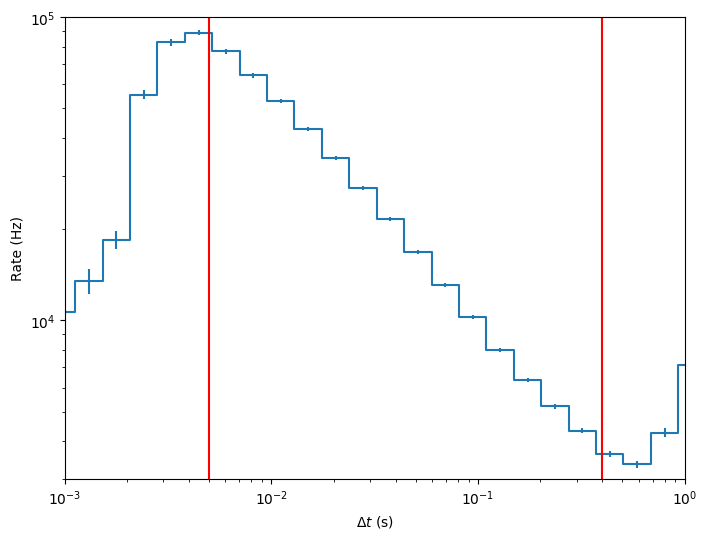

In [33]:
xlim=[1e-3, 1]
ylim=[3e3, 1e5]
error_locations = 10**(log_histogram_bins[:-1] + np.diff(log_histogram_bins)/2) #np.diff
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.step(histogram_bins, np.concatenate([weighted_hist, [weighted_hist[-1]]]), where='post') #for bin width
ax.errorbar(error_locations, weighted_hist, yerr=hist_errs*20, fmt='none', label='data (20 sigma error bars)')
#ax.plot(histogram_bins, 2e3*histogram_bins**(-0.72), label='slope = -0.72')
#ax.vlines(x=[max_drift_time_s], ymin=ylim[0], ymax=ylim[1], color='k', linestyle=':')
ax.set(xscale='log', yscale='log', xlim=xlim, ylim=ylim, xlabel='$\Delta t$ (s)', ylabel='Rate (Hz)')
plt.axvline(0.005,color='r')
plt.axvline(0.4,color='r')
#ax.legend()
plt.savefig('single-photon train.png')
plt.show()

In [37]:
dfs = dfs[(dfs['lone_hit_dt']*1e-9>0.005)&(dfs['lone_hit_dt']*1e-9<0.4)]

In [45]:
result.to_hdf('lonehits.h5', key='name', mode='w')

In [82]:
result['primary_position'] = (result['primary_x'])**2+(result['primary_y'])**2
primaries = result.drop_duplicates('primary_position')

In [84]:
primaries

,lone_hit_channel,lone_hit_dt,primary_x,primary_y,i,array,x,y,primary_position
0,238,5059584.0,35.832722,-8.904020,238,top,55.50120,32.043600,1363.265523
3,238,7594496.0,47.870201,11.741625,238,top,55.50120,32.043600,2429.421908
11,238,49985024.0,-33.772346,-23.015478,238,top,55.50120,32.043600,1670.283622
14,238,5244416.0,-51.706535,-21.773447,238,top,55.50120,32.043600,3147.648793
26,238,48627712.0,-18.547125,25.888683,238,top,55.50120,32.043600,1014.219765
...,...,...,...,...,...,...,...,...,...
6203099,348,5113600.0,-26.770748,31.513672,348,bottom,-55.50110,16.021800,1709.784471
7926856,60,5229568.0,-13.242571,44.669018,60,top,-6.93765,-28.038200,2170.686834
8290796,181,5669632.0,-23.002525,-52.740135,181,top,-27.75060,40.054500,3310.638032
9499683,163,5098496.0,-29.670713,2.818630,163,top,-20.81290,28.038200,888.295913


In [86]:
primaries_center = primaries[primaries['primary_position']<225]

In [87]:
primaries_center

,lone_hit_channel,lone_hit_dt,primary_x,primary_y,i,array,x,y,primary_position
542,238,6749696.0,6.617064,-12.026949,238,top,55.5012,32.0436,188.433043
741,238,12340224.0,-5.455595,-1.065898,238,top,55.5012,32.0436,30.899662
871,238,21501952.0,8.937057,1.734209,238,top,55.5012,32.0436,82.878477
1039,238,118714880.0,-2.696109,6.113966,238,top,55.5012,32.0436,44.649577
1187,238,84130304.0,4.464291,-2.505431,238,top,55.5012,32.0436,26.207079
...,...,...,...,...,...,...,...,...,...
324075,191,23696128.0,6.106461,-10.708514,191,top,13.8753,24.0327,151.961137
362297,213,5506304.0,-2.579222,-2.851879,213,top,62.4388,12.0164,14.785602
489200,361,5141504.0,-5.164237,3.378370,361,bottom,-34.6882,12.0163,38.082723
943422,433,6960640.0,-8.393744,1.018270,433,bottom,34.6882,12.0164,71.491819


In [88]:
primaries_edge = primaries[primaries['primary_position']>62**2]
primaries_edge

,lone_hit_channel,lone_hit_dt,primary_x,primary_y,i,array,x,y,primary_position
168,238,321836544.0,26.736238,57.985130,238,top,55.5012,32.04360,4077.101785
169,238,17545216.0,53.755287,-38.178577,238,top,55.5012,32.04360,4347.234673
496,238,8095744.0,-42.214447,-49.953373,238,top,55.5012,32.04360,4277.399007
850,238,23269376.0,10.118379,61.668613,238,top,55.5012,32.04360,3905.399469
1161,238,6920704.0,-51.143711,-37.443375,238,top,55.5012,32.04360,4017.685488
...,...,...,...,...,...,...,...,...,...
446092,382,19673600.0,-33.380096,56.705696,382,bottom,55.5011,-24.03270,4329.766809
550449,249,6787328.0,64.317390,-0.470057,249,top,34.6882,52.07090,4136.947667
1035559,155,20555264.0,63.504955,-12.439602,155,top,34.6882,-4.00544,4187.623042
1126762,360,5300480.0,-33.583591,52.257206,360,bottom,-27.7506,8.01090,3858.673191


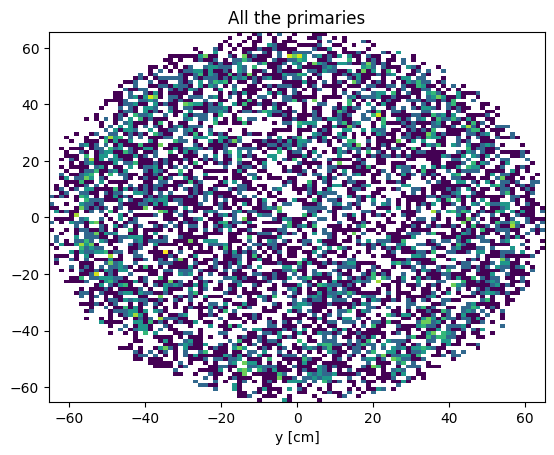

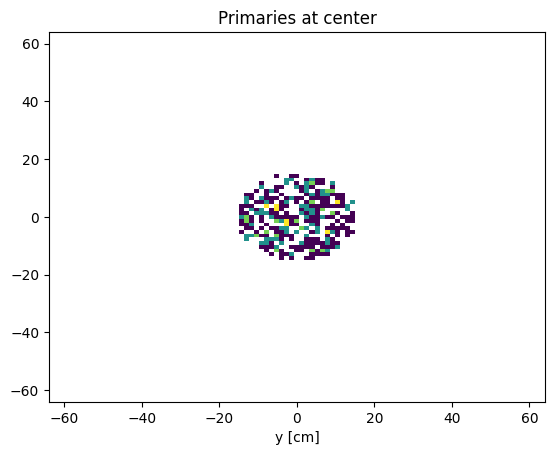

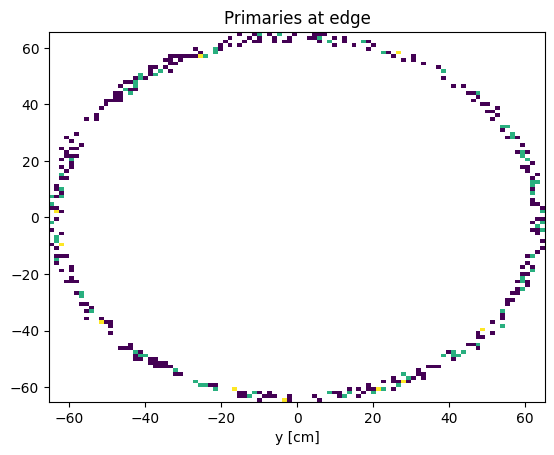

In [90]:
plt.hist2d(primaries['primary_x'],primaries['primary_y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('All the primaries')
plt.show()
plt.hist2d(primaries_center['primary_x'],primaries_center['primary_y'],bins=[np.linspace(-64,64,100),np.linspace(-64,64,100)],norm=colors.LogNorm())
plt.xlim(-64,64)
plt.ylim(-64,64)
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Primaries at center')
plt.show()
plt.hist2d(primaries_edge['primary_x'],primaries_edge['primary_y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Primaries at edge')
plt.show()

In [46]:
result = pd.merge(dfs, PMT_position, left_on='lone_hit_channel', right_on='i', how='inner')
result_top = result[result['array']=='top']
result_bottom = result[result['array']=='bottom']

In [48]:
result_top['dr_square'] = (result_top['x']-result_top['primary_x'])**2+(result_top['y']-result_top['primary_y'])**2

/tmp/ipykernel_3832995/1302601350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_top['dr_square'] = (result_top['x']-result_top['primary_x'])**2+(result_top['y']-result_top['primary_y'])**2


In [50]:
result_bottom['dr_square'] = (result_bottom['x']-result_bottom['primary_x'])**2+(result_bottom['y']-result_bottom['primary_y'])**2

/tmp/ipykernel_3832995/2986769693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_bottom['dr_square'] = (result_bottom['x']-result_bottom['primary_x'])**2+(result_bottom['y']-result_bottom['primary_y'])**2


In [68]:
result_top['primary_position'] = (result_top['primary_x'])**2+(result_top['primary_y'])**2
result_bottom['primary_position'] = (result_bottom['primary_x'])**2+(result_bottom['primary_y'])**2

/tmp/ipykernel_3832995/2518843949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_top['primary_position'] = (result_top['primary_x'])**2+(result_top['primary_y'])**2
/tmp/ipykernel_3832995/2518843949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_bottom['primary_position'] = (result_bottom['primary_x'])**2+(result_bottom['primary_y'])**2


In [75]:
result_top_primaries_at_center = result_top[result_top['primary_position']<225]
result_bottom_primaries_at_center = result_bottom[result_bottom['primary_position']<225]

In [93]:
result_top_primaries_at_edge = result_top[result_top['primary_position']>62**2]
result_bottom_primaries_at_edge = result_bottom[result_bottom['primary_position']>62**2]

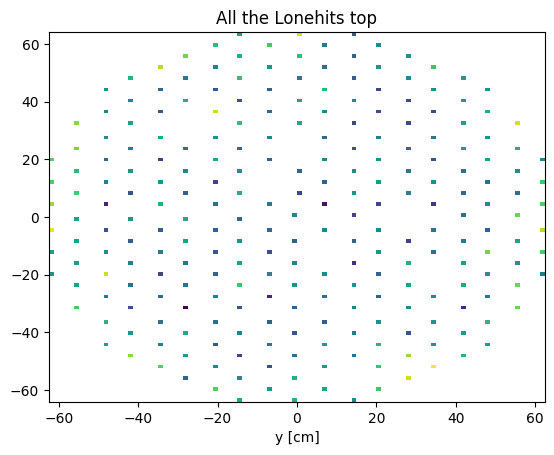

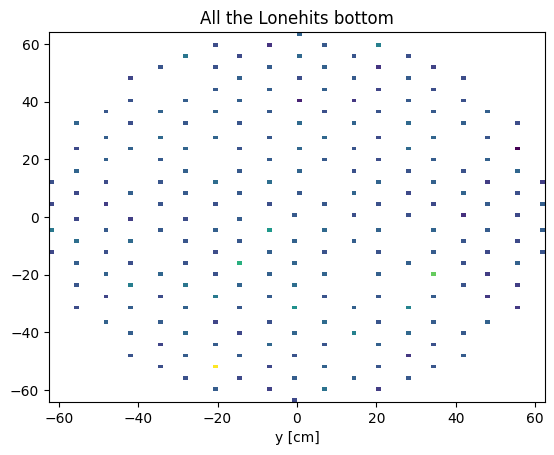

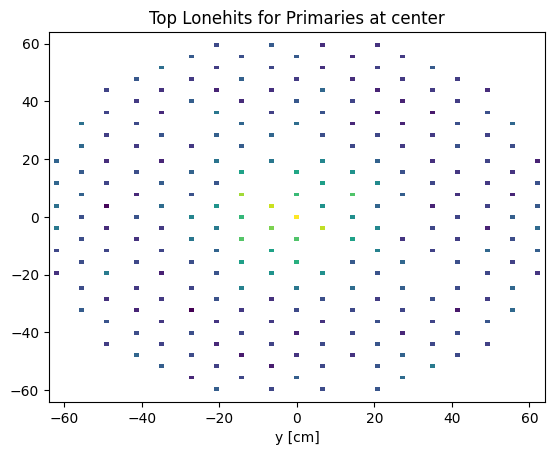

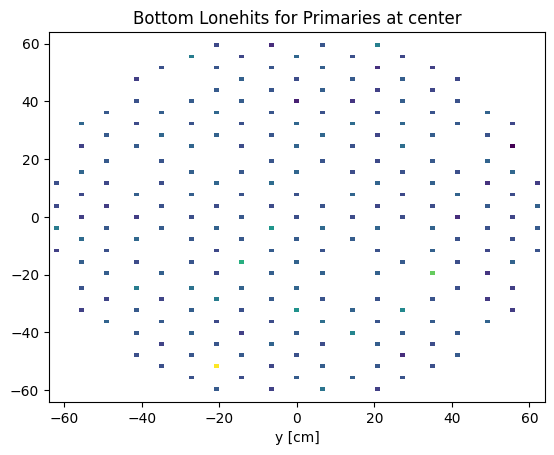

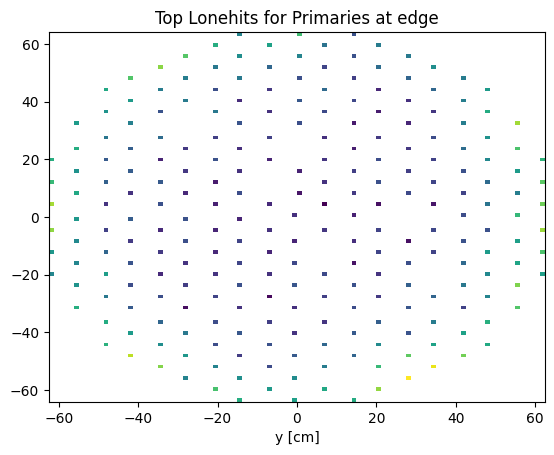

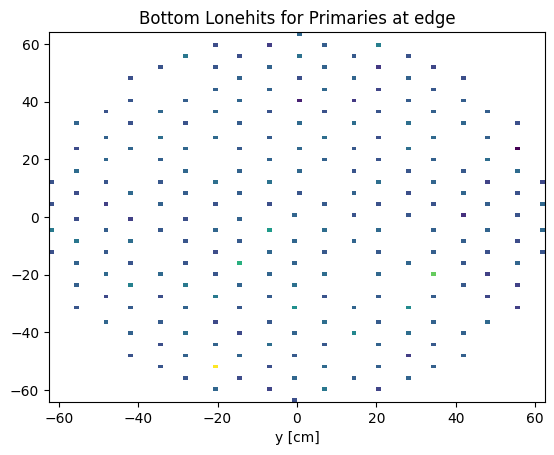

In [94]:
plt.hist2d(result_top['x'],result_top['y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('All the Lonehits top')
plt.show()
plt.hist2d(result_bottom['x'],result_bottom['y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('All the Lonehits bottom')
plt.show()
plt.hist2d(result_top_primaries_at_center['x'],result_top_primaries_at_center['y'],bins=[np.linspace(-64,64,100),np.linspace(-64,64,100)],norm=colors.LogNorm())
plt.xlim(-64,64)
plt.ylim(-64,64)
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Top Lonehits for Primaries at center')
plt.show()
plt.hist2d(result_bottom_primaries_at_center['x'],result_bottom_primaries_at_center['y'],bins=[np.linspace(-64,64,100),np.linspace(-64,64,100)],norm=colors.LogNorm())
plt.xlim(-64,64)
plt.ylim(-64,64)
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Bottom Lonehits for Primaries at center')
plt.show()
plt.hist2d(result_top_primaries_at_edge['x'],result_top_primaries_at_edge['y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Top Lonehits for Primaries at edge')
plt.show()
plt.hist2d(result_bottom_primaries_at_edge['x'],result_bottom_primaries_at_edge['y'],bins=100,norm=colors.LogNorm())
plt.xlabel('x [cm]')
plt.xlabel('y [cm]')
plt.title('Bottom Lonehits for Primaries at edge')
plt.show()

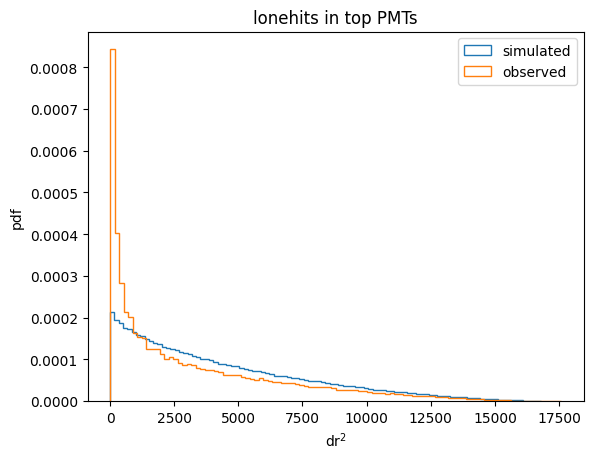

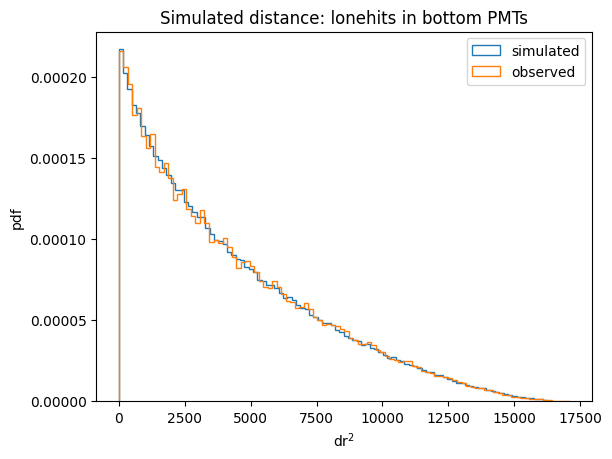

In [102]:
plt.hist(df_lonehit_top['distance_sq'],bins=100,density=True,histtype='step',label='simulated')
plt.hist(result_top['dr_square'],bins=100,density=True,histtype='step',label='observed')
plt.xlabel(r"dr$^2$")
plt.ylabel('pdf')
plt.title('lonehits in top PMTs')
plt.legend()
plt.savefig('Simulated vs Observed distance: lonehits in top PMTs.svg')
plt.show()

plt.hist(df_lonehit_bottom['distance_sq'],bins=100,density=True,histtype='step',label='simulated')
plt.hist(result_bottom['dr_square'],bins=100,density=True,histtype='step',label='observed')
plt.xlabel(r"dr$^2$")
plt.ylabel('pdf')
plt.title('Simulated distance: lonehits in bottom PMTs')
plt.legend()
plt.savefig('Simulated vs Observed distance: lonehits in bottom PMTs.svg')
plt.show()

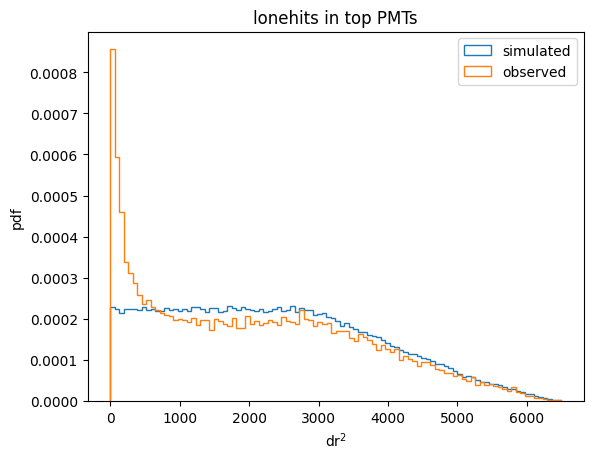

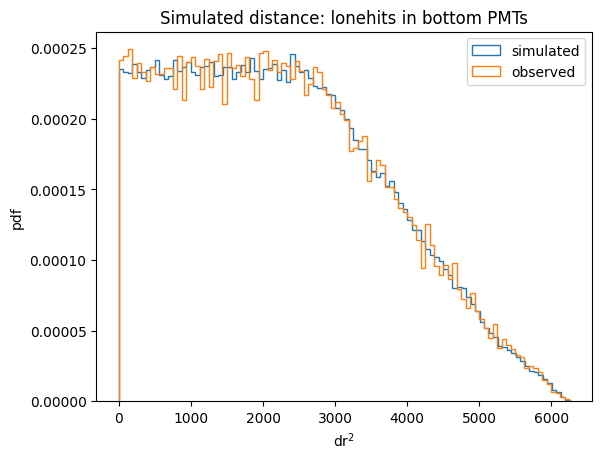

In [100]:
plt.hist(top_lonehit_of_primaries_at_center['distance_sq'],bins=100,density=True,histtype='step',label='simulated')
plt.hist(result_top_primaries_at_center['dr_square'],bins=100,density=True,histtype='step',label='observed')
plt.xlabel(r"dr$^2$")
plt.ylabel('pdf')
plt.title('lonehits in top PMTs')
plt.legend()
plt.savefig('Simulated vs Observed distance: lonehits in top PMTs center primaries.svg')
plt.show()

plt.hist(bottom_lonehit_of_primaries_at_center['distance_sq'],bins=100,density=True,histtype='step',label='simulated')
plt.hist(result_bottom_primaries_at_center['dr_square'],bins=100,density=True,histtype='step',label='observed')
plt.xlabel(r"dr$^2$")
plt.ylabel('pdf')
plt.title('Simulated distance: lonehits in bottom PMTs')
plt.legend()
plt.savefig('Simulated vs Observed distance: lonehits in bottom PMTs center primaries.svg')
plt.show()

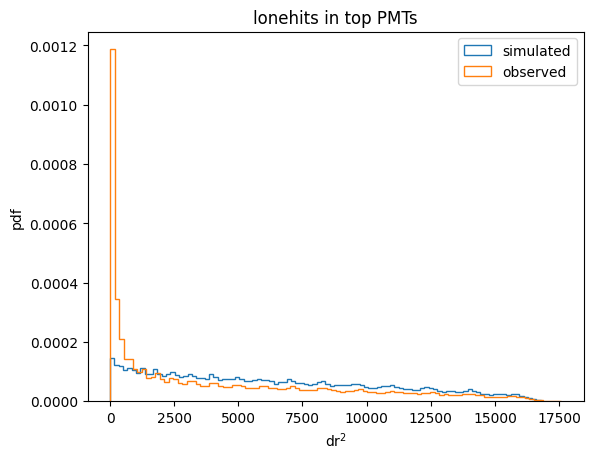

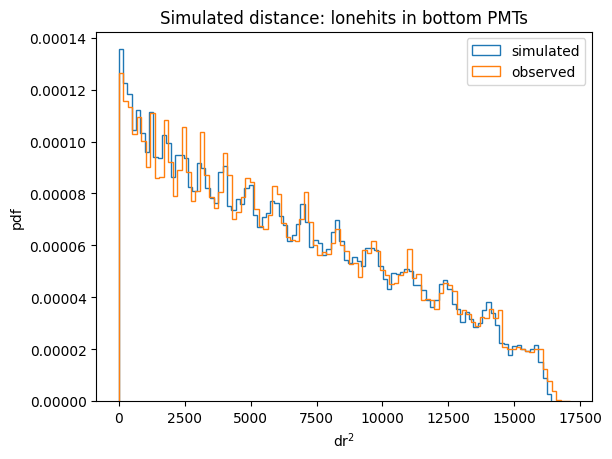

In [101]:
plt.hist(top_lonehit_of_primaries_at_edge['distance_sq'],bins=100,density=True,histtype='step',label='simulated')
plt.hist(result_top_primaries_at_edge['dr_square'],bins=100,density=True,histtype='step',label='observed')
plt.xlabel(r"dr$^2$")
plt.ylabel('pdf')
plt.title('lonehits in top PMTs')
plt.legend()
plt.savefig('Simulated vs Observed distance: lonehits in top PMTs edge primaries.svg')
plt.show()

plt.hist(bottom_lonehit_of_primaries_at_edge['distance_sq'],bins=100,density=True,histtype='step',label='simulated')
plt.hist(result_bottom_primaries_at_edge['dr_square'],bins=100,density=True,histtype='step',label='observed')
plt.xlabel(r"dr$^2$")
plt.ylabel('pdf')
plt.title('Simulated distance: lonehits in bottom PMTs')
plt.legend()
plt.savefig('Simulated vs Observed distance: lonehits in bottom PMTs edge primaries.svg')
plt.show()

In [68]:
result

,lone_hit_channel,lone_hit_dt,primary_x,primary_y,i,array,x,y
0,307,4016384.0,12.196425,14.842037,307,bottom,6.93763,-36.0491
1,307,7726080.0,12.196425,14.842037,307,bottom,6.93763,-36.0491
2,307,18867968.0,12.196425,14.842037,307,bottom,6.93763,-36.0491
3,307,18868736.0,12.196425,14.842037,307,bottom,6.93763,-36.0491
4,307,26297088.0,12.196425,14.842037,307,bottom,6.93763,-36.0491
...,...,...,...,...,...,...,...,...
961878,166,23148800.0,52.986435,2.675718,166,top,-41.62590,40.0545
961879,166,49880576.0,-55.171886,23.144575,166,top,-41.62590,40.0545
961880,166,136304384.0,-55.171886,23.144575,166,top,-41.62590,40.0545
961881,166,19463424.0,18.298252,-42.985924,166,top,-41.62590,40.0545


/tmp/ipykernel_3817670/2519170452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_top['dr_sq'] = ((result_top['x']-result_top['primary_x'])**2 + (result_top['y']-result_top['primary_y'])**2)


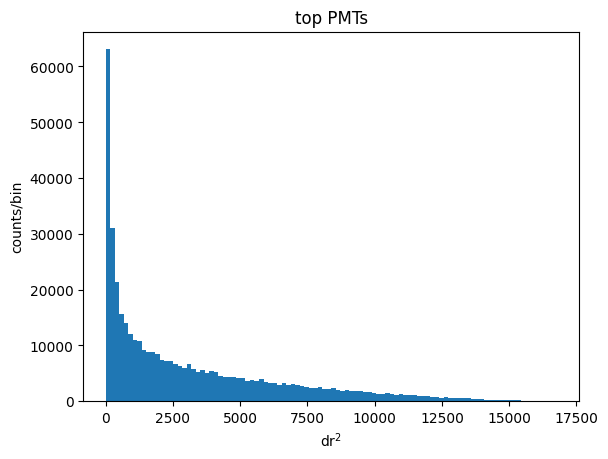

/tmp/ipykernel_3817670/2519170452.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_bottom['dr_sq'] = ((result_bottom['x']-result_bottom['primary_x'])**2 + (result_bottom['y']-result_bottom['primary_y'])**2)


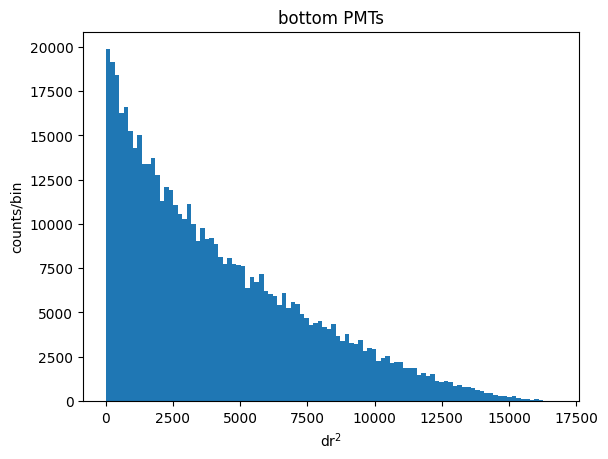

In [67]:
result_top = result[result['array']=='top']
result_top['dr_sq'] = ((result_top['x']-result_top['primary_x'])**2 + (result_top['y']-result_top['primary_y'])**2)
plt.hist(result_top['dr_sq'],bins=100)
plt.xlabel(r"dr$^2$")
plt.ylabel('counts/bin')
plt.title('top PMTs')
plt.savefig('Run 055768: lonehits in top PMTs.svg')
plt.show()
result_bottom = result[result['array']=='bottom']
result_bottom['dr_sq'] = ((result_bottom['x']-result_bottom['primary_x'])**2 + (result_bottom['y']-result_bottom['primary_y'])**2)
plt.hist(result_bottom['dr_sq'],bins=100)
plt.xlabel(r"dr$^2$")
plt.ylabel('counts/bin')
plt.title('bottom PMTs')
plt.savefig('Run 055768: lonehits in bottom PMTs.svg')
plt.show()